In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
data = pd.read_excel('DataSet_JPCLett.xlsx')
data.shape

(1203, 16)

In [3]:
data.head()

,ID No.,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),HOMO (eV),LUMO (eV),bandgap(eV),SMILES
0,1,PBTTT-C14,S1,2.34,2.34,0.53,9.37,0.48,46.2,22,2.1,724,5.10,3.10,1.88,CC1=CC(CCCCCCCCCCCCCC)=C(C2=CC3=C(S2)C=C(C4=C(...
1,2,PCDTBT,S2,3.60,3.60,0.89,6.92,0.63,73.0,37,1.97,731,5.50,3.60,1.88,CC1=CC(N(C(CCCCCCCC)CCCCCCCC)C2=C3C=CC(C4=CC=C...
2,3,PCPDTBT,S3,5.12,5.12,0.61,15.73,0.53,47.6,26.6,1.79,564,5.30,3.55,1.43,CC1=CC(C(CC(CCCC)CC)(CC(CCCC)CC)C2=C3SC(C4=CC=...
3,4,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.74,93.7,47.5,1.97,1089,5.34,3.69,1.65,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...
4,5,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.74,52.9,28.2,1.88,1089,5.20,3.57,1.63,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...


In [4]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

#prepressing data
x_data = np.array(data.loc[:,'SMILES'])
print(x_data.shape, type(x_data))

polymers= []
for smile in x_data:
    m = Chem.MolFromSmiles(smile)
    polymers.append(m)
    
print(type(polymers), len(polymers))

(1203,) <class 'numpy.ndarray'>
<class 'list'> 1203


## y data processing

In [5]:
#y_data processing, from the average PCE values
y_data = np.array(data.loc[:,'PCE_ave(%)'])
y_data_round = np.around(y_data, decimals=2)
print(type(y_data_round), y_data_round.shape)

<class 'numpy.ndarray'> (1203,)


### Generate fingerprints: Morgan fingerprint with radius 5
### SVM and RF Modelling; apply all the data

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

#Generate polymer fingerprints
fps = [AllChem.GetMorganFingerprintAsBitVect(p, 5) for p in polymers]
    
np_fps = []
for fp in fps:
    arr = np.zeros((1,))  # create a num array to accept the data
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)    # this will change numpy array to list 
    
x_data = np.array(np_fps) # change list to np array
   
model_svm = SVR(C=31, gamma=0.001)
model_svm.fit(x_data, y_data_round)

model_RF = RandomForestRegressor(n_estimators=500)
model_RF.fit(x_data, y_data_round)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [7]:
# Process the data from the Data Science paper
# SMILES from SciData
df_SciData = pd.read_excel('sdata201686-s2.csv.xlsx')
df_SciData.head()

,smiles,confnum,homo,lumo,gap
0,COC(=O)/C(=C/c1cc(C)c(c2ccc(c3sc(c4cc5c(s4)c(O...,0.0,-0.246,-0.011,0.235
1,Cc1csc(c2ccc(c3cc(C)cs3)c3nsnc23)c1,0.0,-0.259,0.003,0.262
2,COC(=O)/C(=C/c1cc(C)c(c2cc(C)c(c3ccc(c4sc(c5sc...,0.0,-0.251,-0.017,0.234
3,C[Si]1(C)c2ccsc2c2sc(c3nc4sc(c5cc6c(s5)c5sc(c7...,0.0,-0.237,0.008,0.245
4,COc1c2ccsc2c(OC)c2cc(c3sc(c4scc5c4[C@@H]4C=C[C...,0.0,-0.253,0.047,0.300


In [8]:
df_SciData.shape # 316 compounds plus one new structure that we propose

(317, 5)

In [9]:
#prepressing data
x_Scidata = np.array(df_SciData.loc[:,'smiles'])

def NewMaterSmile(data):
    molecules = []
    for smile in data:
        m = Chem.MolFromSmiles(smile)
        molecules.append(m)
    
# generate fingerprint: Morgan fingerprint with radius 5
    fps_new = [AllChem.GetMorganFingerprintAsBitVect(p, 5) for p in molecules]

#convert the RDkit explicit vectors 
    np_fps = []
    for fp in fps_new:
        arr = np.zeros((1,))  # create a num array to accept the data
        DataStructs.ConvertToNumpyArray(fp, arr)  
        np_fps.append(arr)    # this will change numpy array to list
    x_data = np.array(np_fps) # change list back to no array
    return x_data

x_Scidata_Smile = NewMaterSmile(x_Scidata)

# Apply the models

In [10]:
prediction_svm = model_svm.predict(x_Scidata_Smile)
prediction_RF = model_RF.predict(x_Scidata_Smile)

# Average the prediction from the two models
prediction_blend = prediction_svm + prediction_RF
prediction_blend = prediction_blend/2
print(prediction_RF.shape, prediction_svm.shape, prediction_blend.shape)

(317,) (317,) (317,)


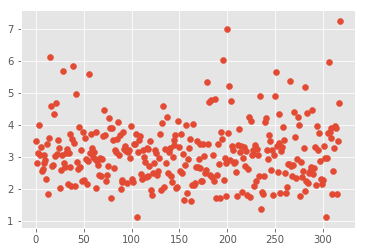

In [11]:
# Check the predictive results
x = np.linspace(0, 318, 317)
plt.scatter(x, prediction_blend)

In [12]:
# The resutls of the top 7 candidates

argsorted = prediction_blend.argsort()
argsorted[310:317]

array([ 28,  39, 304, 194,  15, 199, 316], dtype=int64)

In [13]:
# To confirm the results
print(prediction_blend[28]) 

5.6944639360410525


In [15]:
top7 = prediction_blend[prediction_blend>5.68]
top7

array([6.13949201, 5.69446394, 5.84473378, 6.03810334, 7.00673649,
       5.95611442, 7.26172149])

In [16]:
# confirm the correction of the top 6 candidates
print(prediction_blend[15], prediction_blend[28], prediction_blend[39], prediction_blend[194], 
      prediction_blend[199], prediction_blend[304], prediction_blend[316]) 

6.139492009200478 5.6944639360410525 5.844733775020877 6.038103342544838 7.006736487024735 5.956114421394325 7.261721487950273


# Change SMILES to Chemical Structures

In [17]:
from rdkit.Chem import Draw

structs = []
for n in [15, 28, 39, 194, 199, 304, 316]:
    mole = df_SciData['smiles'][n]
    structs.append(mole)

PCE = []
for i in [15, 28, 39, 194, 199, 304, 316]:
    Efficiency = prediction_blend[i]
    str_PCE = 'PCE = ' + str(Efficiency.round(2))
    PCE.append(str_PCE)

print(PCE)

['PCE = 6.14', 'PCE = 5.69', 'PCE = 5.84', 'PCE = 6.04', 'PCE = 7.01', 'PCE = 5.96', 'PCE = 7.26']


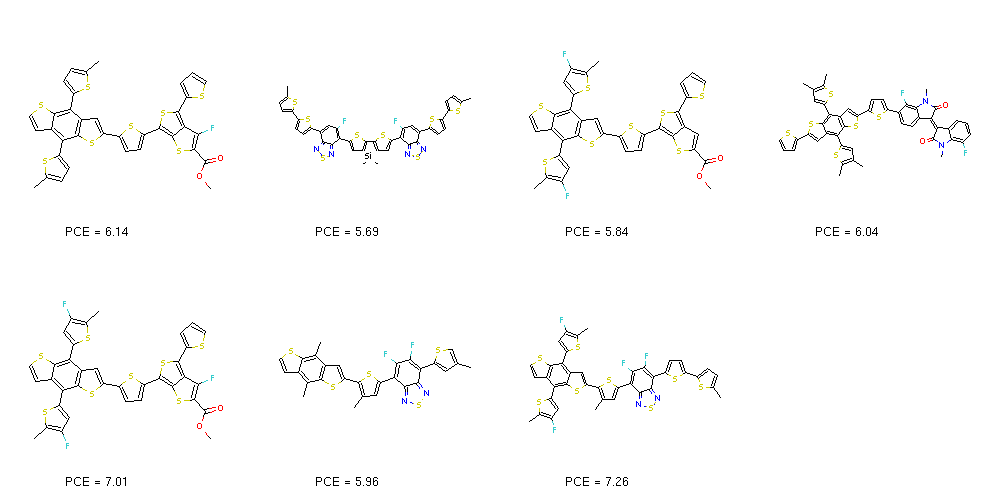

In [18]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in structs], molsPerRow=4, subImgSize=(250,250), legends = PCE)